In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [2]:
# carrega o dataset
dataset_url = "BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [3]:
# definição de dimensões da imagem
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

# define pasta de treino
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

# define pasta de validação
valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [4]:
# dimensionamento
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# escala de (0, 255) até  (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [5]:
# for batch in train_ds.take(1):
#     for img in batch:
#         display(array_to_img(img))

In [6]:
# preparação de dataset de teste
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [7]:
# conversão de rgb para yuv
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [8]:
# for batch in train_ds.take(1):
#     for img in batch[0]:
#         display(array_to_img(img))
#     for img in batch[1]:
#         display(array_to_img(img))

In [9]:
# construção do modelo
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [10]:
# libs de utilidade
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [11]:
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


In [12]:
# converter a imagem para baixa resolução
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

In [13]:
# retorna imagem reconstruída em alta resolução
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [14]:
# callbacks para monitorar o treinamento
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [15]:
# checkpoint
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

Epoch 1/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.72


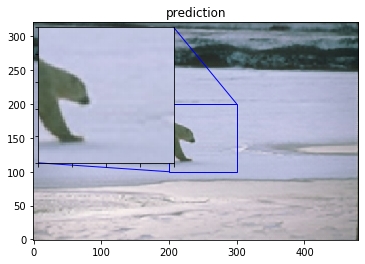

Epoch 2/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0023
Mean PSNR for epoch: 26.43
Epoch 3/1000
50/50 - 16s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 4/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.59
Epoch 5/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.72
Epoch 6/1000
50/50 - 17s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.50
Epoch 7/1000
50/50 - 16s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 8/1000
50/50 - 16s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.74
Epoch 9/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.72
Epoch 10/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.69
Epoch 11/1000
50/50 - 15s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.18
Epoch 12/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.56
Epoch 13/1000
50/50 - 15s - loss: 0.0024 - val_loss

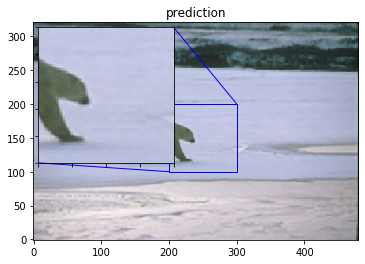

Epoch 22/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.76
Epoch 23/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 27.06
Epoch 24/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.31
Epoch 25/1000
50/50 - 17s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 27.04
Epoch 26/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.76
Epoch 27/1000
50/50 - 17s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.69
Epoch 28/1000
50/50 - 16s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.97
Epoch 29/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.64
Epoch 30/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.88
Epoch 31/1000
50/50 - 15s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.61
Epoch 32/1000
50/50 - 15s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.66
Epoch 33/1000
50/50 - 15s - loss: 0.0024 - 

In [28]:
# treino
epochs = 1000

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

model.load_weights(checkpoint_filepath)

PSNR da imagem de baixa resolução e alta resolução: 28.4183
PSNR da predição e alta resolução: 30.0197


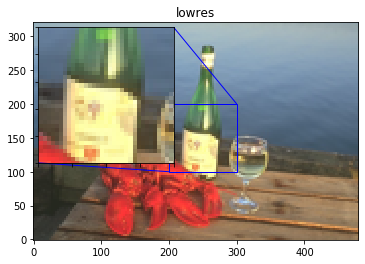

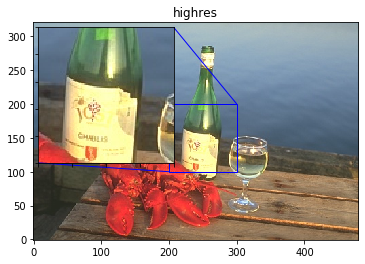

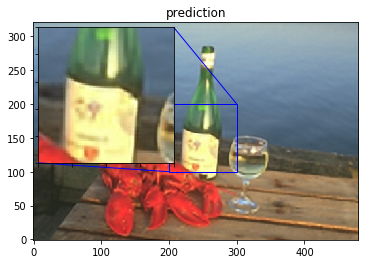

PSNR da imagem de baixa resolução e alta resolução: 23.1691
PSNR da predição e alta resolução: 25.3819


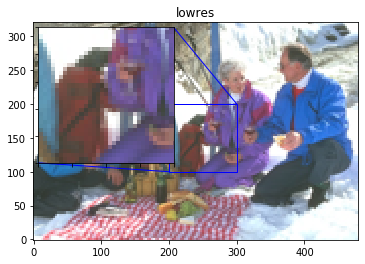

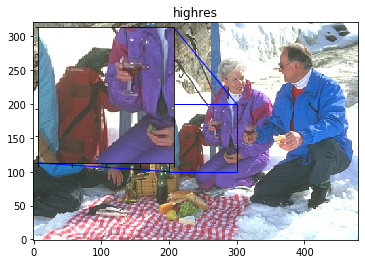

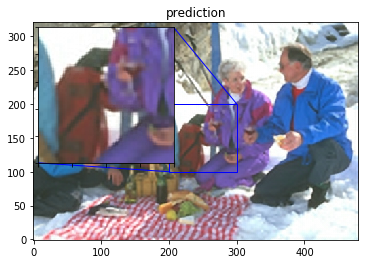

PSNR da imagem de baixa resolução e alta resolução: 25.4171
PSNR da predição e alta resolução: 27.4176


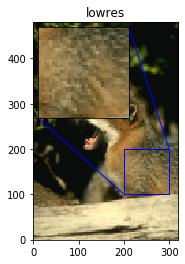

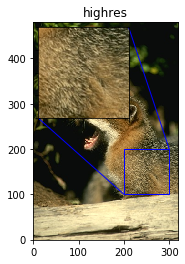

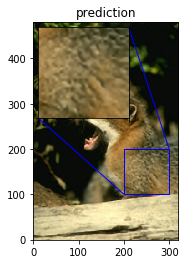

PSNR da imagem de baixa resolução e alta resolução: 26.5188
PSNR da predição e alta resolução: 27.0918


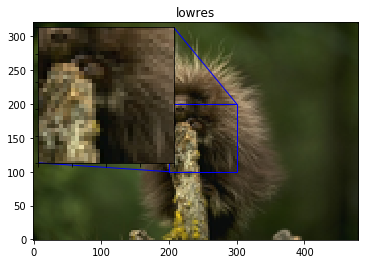

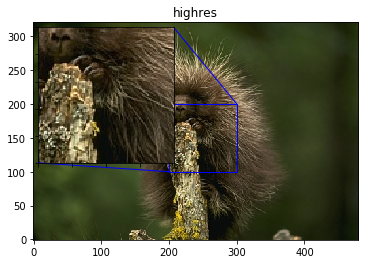

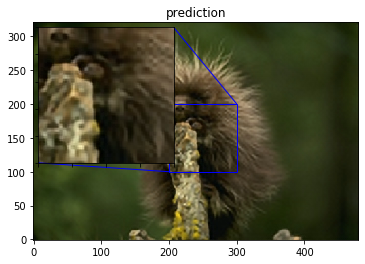

PSNR da imagem de baixa resolução e alta resolução: 24.2763
PSNR da predição e alta resolução: 25.8613


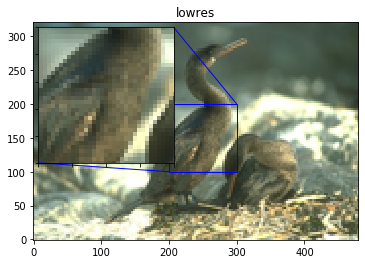

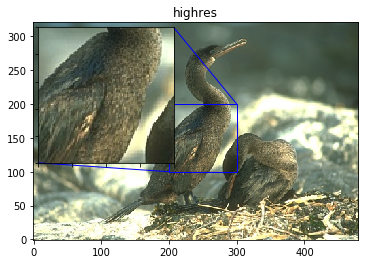

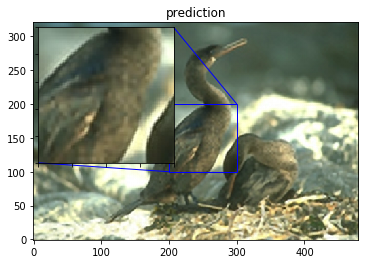

PSNR da imagem de baixa resolução e alta resolução: 24.0756
PSNR da predição e alta resolução: 26.1985


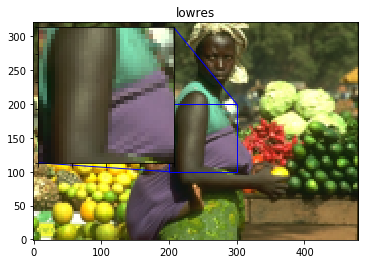

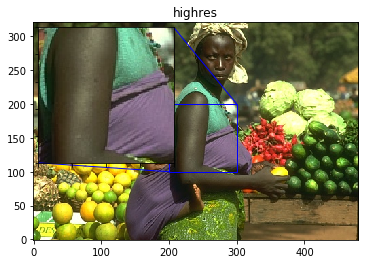

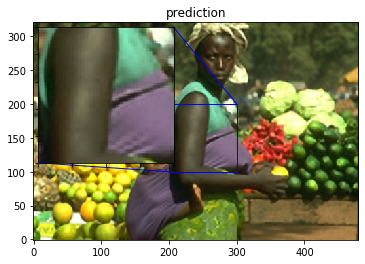

PSNR da imagem de baixa resolução e alta resolução: 24.2946
PSNR da predição e alta resolução: 26.4492


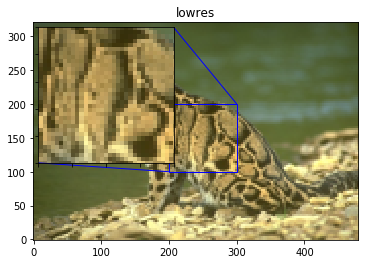

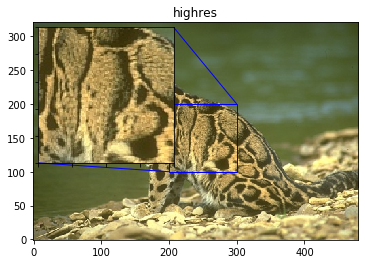

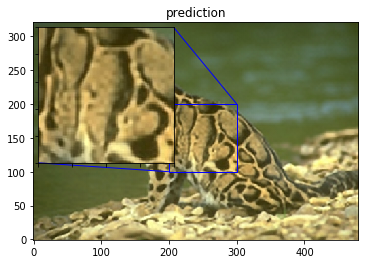

PSNR da imagem de baixa resolução e alta resolução: 21.6846
PSNR da predição e alta resolução: 24.0130


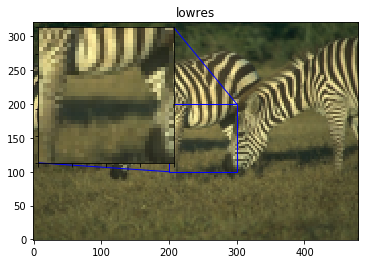

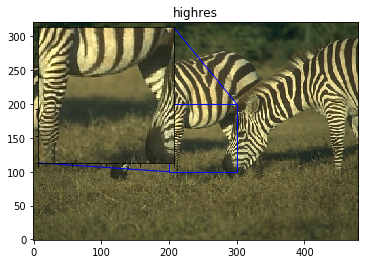

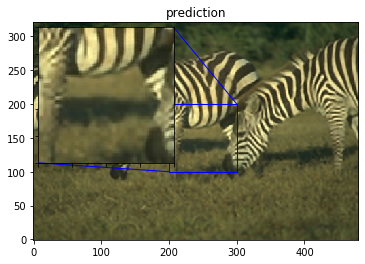

PSNR da imagem de baixa resolução e alta resolução: 28.8639
PSNR da predição e alta resolução: 29.6213


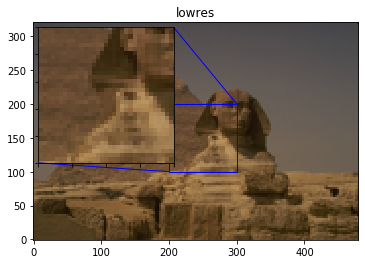

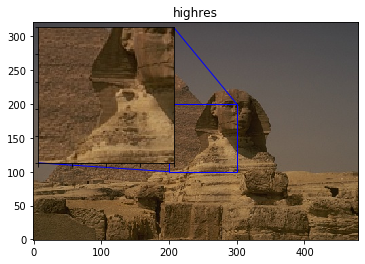

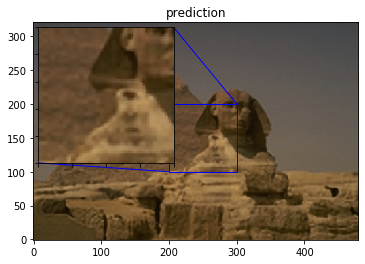

PSNR da imagem de baixa resolução e alta resolução: 23.9976
PSNR da predição e alta resolução: 25.3538


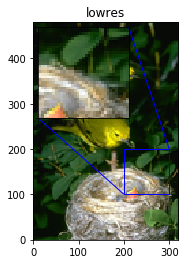

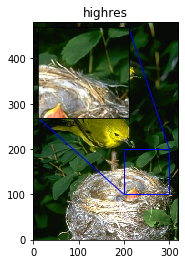

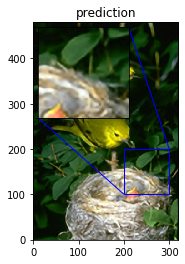

Med. PSNR de baixa res:  25.0716
Med. PSNR da reconstrução: 26.7408


In [23]:
# redimensionar e salvar imagens
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR da imagem de baixa resolução e alta resolução: %.4f" % bicubic_psnr
    )
    print("PSNR da predição e alta resolução: %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Med. PSNR de baixa res:  %.4f" % (total_bicubic_psnr / 10))
print("Med. PSNR da reconstrução: %.4f" % (total_test_psnr / 10))

In [24]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [25]:
saved_model = tf.keras.models.load_model('saved_model/my_model')

In [26]:
saved_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

In [27]:
model.save_weights('./checkpoints/my_checkpoint')